<a href="https://colab.research.google.com/github/jlb-jlb/ML_Notebooks/blob/main/Training_script_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Vision Transformer for Seizure Classification

## Installing Dependencies

In [1]:
# blocks output in Colab 💄
%%capture

! pip install -q datasets transformers[torch]

! pip install -q evaluate

## Huggingface login

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Google Login

In [4]:
from google.colab import drive
# "/content/drive/MyDrive/Model_folder"
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load Dataset

In [5]:
from datasets import load_dataset

# load dataset

# dataset = load_dataset("JLB-JLB/seizure_eeg_greyscale_224x224_6secWindow")  # Load from Huggingface
# save dataset to google drive
# dataset.save_to_disk("/content/drive/MyDrive/Seizure_EEG_Research/Dataset") # save to drive

dataset = load_dataset("/content/drive/MyDrive/Seizure_EEG_Research/Dataset") # load from drive

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 814568
    })
    validation: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
    test: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 114035
    })
})

In [ ]:
example = dataset["train"][400]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>,
 'epoch': 124,
 'label': 1}

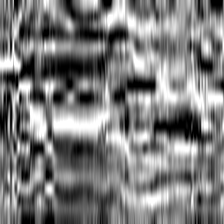

In [ ]:
image = example["image"]
image

In [ ]:
labels = dataset["train"].features["label"]
labels

ClassLabel(names=['seiz', 'bckg'], id=None)

In [ ]:
labels.int2str(example['label'])

'bckg'

In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255)) #, font=font)

    return grid

# show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)


## Load model

In [6]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
model_name_or_path = "/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
feature_extractor(image.convert("RGB"), return_tensors='pt')

{'pixel_values': tensor([[[[ 0.1451,  0.0902,  0.0431,  ..., -1.0000, -0.8667, -0.0588],
          [ 0.1373,  0.0824,  0.0431,  ..., -1.0000, -0.8431, -0.0510],
          [ 0.1294,  0.0745,  0.0353,  ..., -1.0000, -0.8196, -0.0510],
          ...,
          [ 0.0980, -0.0980,  0.0275,  ...,  0.0196, -0.2627,  0.1059],
          [ 0.0980, -0.0980,  0.0275,  ...,  0.0039, -0.2863,  0.0980],
          [ 0.0980, -0.0980,  0.0275,  ..., -0.0118, -0.3098,  0.0902]],

         [[ 0.1451,  0.0902,  0.0431,  ..., -1.0000, -0.8667, -0.0588],
          [ 0.1373,  0.0824,  0.0431,  ..., -1.0000, -0.8431, -0.0510],
          [ 0.1294,  0.0745,  0.0353,  ..., -1.0000, -0.8196, -0.0510],
          ...,
          [ 0.0980, -0.0980,  0.0275,  ...,  0.0196, -0.2627,  0.1059],
          [ 0.0980, -0.0980,  0.0275,  ...,  0.0039, -0.2863,  0.0980],
          [ 0.0980, -0.0980,  0.0275,  ..., -0.0118, -0.3098,  0.0902]],

         [[ 0.1451,  0.0902,  0.0431,  ..., -1.0000, -0.8667, -0.0588],
          [ 0

In [7]:
def process_example(example):
    inputs = feature_extractor(example['image'].convert("RGB"), return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0.7882, -0.1216, -0.7176,  ...,  0.0431,  0.0431,  0.0745],
          [-0.7725, -0.1294, -0.6941,  ...,  0.0510,  0.0510,  0.0745],
          ...,
          [-0.1294, -0.6549, -0.5451,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0980, -0.6863, -0.5686,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0824, -0.7098, -0.5843,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0.7882, -0.1216, -0.7176,  ...,  0.0431,  0.0431,  0.0745],
          [-0.7725, -0.1294, -0.6941,  ...,  0.0510,  0.0510,  0.0745],
          ...,
          [-0.1294, -0.6549, -0.5451,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0980, -0.6863, -0.5686,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0824, -0.7098, -0.5843,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0

In [8]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs


prepared_ds = dataset.with_transform(transform)

In [ ]:
prepared_ds["train"][0:2]

{'pixel_values': tensor([[[[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0.7882, -0.1216, -0.7176,  ...,  0.0431,  0.0431,  0.0745],
          [-0.7725, -0.1294, -0.6941,  ...,  0.0510,  0.0510,  0.0745],
          ...,
          [-0.1294, -0.6549, -0.5451,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0980, -0.6863, -0.5686,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0824, -0.7098, -0.5843,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0.7882, -0.1216, -0.7176,  ...,  0.0431,  0.0431,  0.0745],
          [-0.7725, -0.1294, -0.6941,  ...,  0.0510,  0.0510,  0.0745],
          ...,
          [-0.1294, -0.6549, -0.5451,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0980, -0.6863, -0.5686,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0824, -0.7098, -0.5843,  ...,  1.0000,  1.0000,  1.0000]],

         [[-0.8039, -0.1216, -0.7333,  ...,  0.0431,  0.0431,  0.0667],
          [-0

## Training and Eval

In [9]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [10]:
# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
import numpy as np
import evaluate

metric_matthews_corrcoef = evaluate.load("matthews_correlation")
roc_auc_score = evaluate.load("roc_auc")
# metric



print(metric_matthews_corrcoef.description)
print(roc_auc_score.description)

def compute_metrics(eval_preds):
    predictions = np.argmax(eval_preds.predictions, axis=1)
    references = eval_preds.label_ids
    try:
        print(f"Predictions: {predictions[0:20]}")
        print(f"References:  {references[0:20]}")
    except:
        print("ERROR PRINTING compute metrics")

    try:
        results_roc_auc_score = roc_auc_score.compute(prediction_scores=predictions, references=references)
        print(results_roc_auc_score)
    except:
        print("Error computing roc_auc_score")

    return metric_matthews_corrcoef.compute(predictions=predictions, references=references)



Compute the Matthews correlation coefficient (MCC)

The Matthews correlation coefficient is used in machine learning as a
measure of the quality of binary and multiclass classifications. It takes
into account true and false positives and negatives and is generally
regarded as a balanced measure which can be used even if the classes are of
very different sizes. The MCC is in essence a correlation coefficient value
between -1 and +1. A coefficient of +1 represents a perfect prediction, 0
an average random prediction and -1 an inverse prediction.  The statistic
is also known as the phi coefficient. [source: Wikipedia]


This metric computes the area under the curve (AUC) for the Receiver Operating Characteristic Curve (ROC). The return values represent how well the model used is predicting the correct classes, based on the input data. A score of `0.5` means that the model is predicting exactly at chance, i.e. the model's predictions are correct at the same rate as if the predictions were

In [12]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    # model_name_or_path,
    "/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

In [13]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir= "/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection", #"./model_vit_eeg",
  per_device_train_batch_size=64, # T4: 64, V100: 64, A100: 256
  evaluation_strategy="steps",
  num_train_epochs=4,
#   fp16=True,
  save_steps=10000,
  eval_steps=10000,
  logging_steps=20,
  learning_rate=1e-4,
  save_total_limit=4,
  remove_unused_columns=False,
  resume_from_checkpoint=True,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [15]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 814568
    })
    validation: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
    test: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 114035
    })
})

In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [17]:
trainer

In [18]:
train_results = trainer.train("/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection/checkpoint-40000") # "/content/drive/MyDrive/Model_folder/checkpoint-30")
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Matthews Correlation
50000,0.009200,0.349536,0.438919


Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
References:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{'roc_auc': 0.653558713889643}


training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =            4.0
  total_flos               = 235149618224GF
  train_loss               =         0.0029
  train_runtime            =     3:22:40.52
  train_samples_per_second =        267.939
  train_steps_per_second   =          4.187


In [19]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Predictions: [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
References:  [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'roc_auc': 0.6467466722567721}
***** eval metrics *****
  epoch                     =        4.0
  eval_loss                 =     0.1622
  eval_matthews_correlation =      0.411
  eval_runtime              = 1:04:46.26
  eval_samples_per_second   =    100.402
  eval_steps_per_second     =      12.55


In [20]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'dsf',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('VIT_SEIZURE_224x224_greyscale_6secWindow_231023', **kwargs)
else:
    trainer.create_model_card(**kwargs)

In [ ]:
!fusermount -u drive
!google-drive-ocamlfuse drive

/bin/bash: line 1: google-drive-ocamlfuse: command not found


In [ ]:
from google.colab import runtime
runtime.unassign()

---

# EVALUTATION

In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 814568
    })
    validation: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
    test: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 114035
    })
})


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
# "/content/drive/MyDrive/Model_folder"
drive.mount('/content/drive', force_remount=True)

In [ ]:
# load validation data

from datasets import load_data

dataset_validation = load_dataset("/content/drive/MyDrive/Seizure_EEG_Research/Dataset") # load from drive
display(dataset_validation)

In [8]:
import evaluate
import random
import torch
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification, TrainingArguments, Trainer

from datasets import load_dataset

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
display(feature_extractor)

def process_example(example):
    inputs = feature_extractor(example['image'].convert("RGB"), return_tensors='pt')
    inputs['label'] = example['label']
    return inputs


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs


prepared_ds = dataset.with_transform(transform)

import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(model_name_or_path,
                                                  num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}).to(device)



# metrics
roc_auc_score = evaluate.load("roc_auc")
metric_matthews_corrcoef = evaluate.load("matthews_correlation")
print(roc_auc_score.description)
print(metric_matthews_corrcoef.description)

def compute_metrics(eval_preds):
    # print(eval_preds)
    predictions = np.argmax(eval_preds.predictions, axis=1)
    references = eval_preds.label_ids

    # print(f"Predictions: {predictions[0:20]}")
    # print(f"References:  {references[0:20]}")




    results_roc_auc_score = roc_auc_score.compute(prediction_scores=predictions, references=references)
    print(results_roc_auc_score)

    # print("Error computing roc_auc_score")
    matthews_correlation =  metric_matthews_corrcoef.compute(predictions=predictions, references=references)
    print(matthews_correlation)
    # return a dictonary of metrics to be used with the Trainer class
    return results_roc_auc_score

from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir= "/content/drive/MyDrive/Seizure_EEG_Research/evaluation", #"./model_vit_eeg",
  per_device_train_batch_size=8, # T4: 64, V100: 64, A100: 256
  evaluation_strategy="steps",
  num_train_epochs=4,
#   fp16=True,
  save_steps=10000,
  eval_steps=10000,
  logging_steps=20,
  learning_rate=1e-4,
  save_total_limit=4,
  remove_unused_columns=False,
  resume_from_checkpoint=True,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    # eval_dataset=dataset_eval_balanced_total_prepared,
    tokenizer=feature_extractor,
)



/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}


This metric computes the area under the curve (AUC) for the Receiver Operating Characteristic Curve (ROC). The return values represent how well the model used is predicting the correct classes, based on the input data. A score of `0.5` means that the model is predicting exactly at chance, i.e. the model's predictions are correct at the same rate as if the predictions were being decided by the flip of a fair coin or the roll of a fair die. A score above `0.5` indicates that the model is doing better than chance, while a score below `0.5` indicates that the model is doing worse than chance.

This metric has three separate use cases:
    - binary: The case in which there are only two different label classes, and each example gets only one label. This is the default implementation.
    - multiclass: The case in which there can be more than two different label classes, but each example still gets only one label.
    - multilabel: The case in which there can be more than two different label

In [11]:
dataset_seiz = dataset["validation"].filter(lambda x: x['label'] == 0)
dataset_bckg = dataset["validation"].filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(19237)) # there are 19237 seizure events

dataset_eval = datasets.concatenate_datasets([dataset_seiz, dataset_bckg]).shuffle(seed=42)
display(dataset_eval)


Filter:   0%|          | 0/390190 [00:00<?, ? examples/s]

Filter:   0%|          | 0/390190 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'epoch', 'label'],
    num_rows: 38474
})

In [12]:
dataset_eval_prepared = dataset_eval.with_transform(transform)

In [16]:
dataset_eval_prepared

Dataset({
    features: ['image', 'epoch', 'label'],
    num_rows: 38474
})

In [13]:
trainer.evaluate(dataset_eval_prepared.select(range(20)))

{'roc_auc': 0.7}
{'matthews_correlation': 0.5}


{'eval_loss': 1.1801629066467285,
 'eval_roc_auc': 0.7,
 'eval_runtime': 6.9533,
 'eval_samples_per_second': 2.876,
 'eval_steps_per_second': 0.431}

In [22]:
predictions = trainer.predict(dataset_eval_prepared)
display(predictions)

{'roc_auc': 0.6465925040286947}
{'matthews_correlation': 0.40301285927502095}


PredictionOutput(predictions=array([[-3.5342321 ,  3.4429936 ],
       [-3.3902786 ,  3.3758922 ],
       [-1.4976045 ,  1.5531579 ],
       ...,
       [ 2.0373702 , -1.8264943 ],
       [-0.401863  ,  0.4976387 ],
       [-0.24405284,  0.33904907]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 0]), metrics={'test_loss': 1.3792541027069092, 'test_roc_auc': 0.6465925040286947, 'test_runtime': 402.0697, 'test_samples_per_second': 95.69, 'test_steps_per_second': 11.963})

In [20]:
dataset_eval_prepared[0]

{'pixel_values': tensor([[[ 1.0000,  0.6157,  0.0902,  ...,  0.1529, -0.6627, -0.6627],
          [ 1.0000,  0.5686,  0.0824,  ...,  0.1529, -0.6314, -0.6392],
          [ 1.0000,  0.5137,  0.0745,  ...,  0.1529, -0.6000, -0.6235],
          ...,
          [ 0.3882, -0.2392,  0.1843,  ..., -0.8039, -1.0000, -1.0000],
          [ 0.3882, -0.2549,  0.1922,  ..., -0.8118, -1.0000, -1.0000],
          [ 0.3882, -0.2627,  0.2000,  ..., -0.8275, -1.0000, -1.0000]],
 
         [[ 1.0000,  0.6157,  0.0902,  ...,  0.1529, -0.6627, -0.6627],
          [ 1.0000,  0.5686,  0.0824,  ...,  0.1529, -0.6314, -0.6392],
          [ 1.0000,  0.5137,  0.0745,  ...,  0.1529, -0.6000, -0.6235],
          ...,
          [ 0.3882, -0.2392,  0.1843,  ..., -0.8039, -1.0000, -1.0000],
          [ 0.3882, -0.2549,  0.1922,  ..., -0.8118, -1.0000, -1.0000],
          [ 0.3882, -0.2627,  0.2000,  ..., -0.8275, -1.0000, -1.0000]],
 
         [[ 1.0000,  0.6157,  0.0902,  ...,  0.1529, -0.6627, -0.6627],
          [ 

In [23]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [26]:
print(len(predictions.predictions))
predictions.predictions

38474


array([[-3.5342321 ,  3.4429936 ],
       [-3.3902786 ,  3.3758922 ],
       [-1.4976045 ,  1.5531579 ],
       ...,
       [ 2.0373702 , -1.8264943 ],
       [-0.401863  ,  0.4976387 ],
       [-0.24405284,  0.33904907]], dtype=float32)

In [27]:
predictions.label_ids

array([1, 1, 1, ..., 0, 1, 0])

In [28]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 5839, 13398],
       [  199, 19038]])

In [29]:
sum(cm)

array([ 6038, 32436])

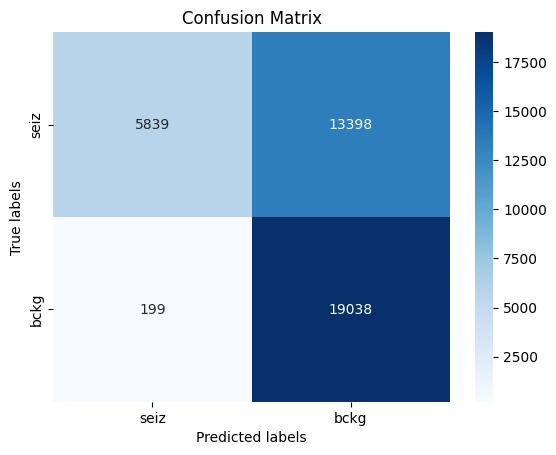

In [32]:
# plot confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)

ax.yaxis.set_ticklabels(labels)

plt.savefig("/content/drive/MyDrive/Seizure_EEG_Research/evaluation/confusion_matrix.png")
# display confusion matrix
plt.show()

In [31]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Corrcoef: {mcc}")

Matthews Corrcoef: 0.40301285927502095


0.6465925040286947


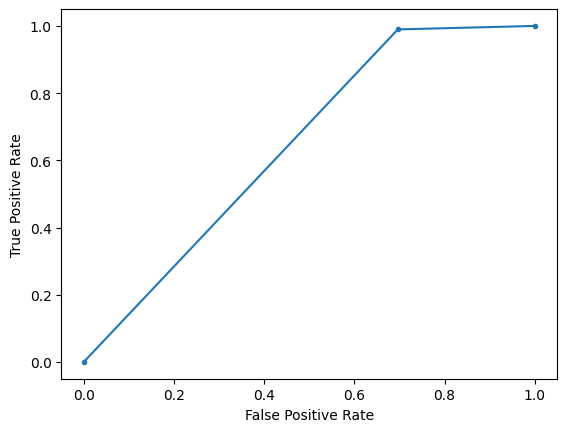

In [34]:
# compute roc_auc
from sklearn.metrics import roc_auc_score
roc_auc_score_ = roc_auc_score(y_true, y_pred)
print(roc_auc_score_)

# plot roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)


# Try AGAIN

In [44]:
len(dataset["train"])

814568

In [45]:
# bckg = 1, seiz = 0
dataset_train_adjusted_seiz = dataset["train"].filter(lambda x: x['label'] == 0)

dataset_train_adjusted_bckg = dataset["train"].filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(len(dataset_train_adjusted_seiz)))

dataset_train_adjusted = datasets.concatenate_datasets([dataset_train_adjusted_seiz, dataset_train_adjusted_bckg]).shuffle(seed=42)
display(dataset_train_adjusted)


dataset_eval_adjusted_seiz = dataset["test"].filter(lambda x: x['label'] == 0)
dataset_eval_adjusted_bckg = dataset["test"].filter(lambda x: x['label'] == 1).shuffle(seed=42).select(range(len(dataset_eval_adjusted_seiz)))
dataset_eval_adjusted = datasets.concatenate_datasets([dataset_eval_adjusted_seiz,  dataset_eval_adjusted_bckg ]).shuffle(seed=42)
display(dataset_eval_adjusted)

Filter:   0%|          | 0/814568 [00:00<?, ? examples/s]

Filter:   0%|          | 0/814568 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'epoch', 'label'],
    num_rows: 93962
})

Filter:   0%|          | 0/114035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/114035 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'epoch', 'label'],
    num_rows: 14910
})

In [51]:
# create datasetdict
datasetDict = datasets.DatasetDict({"train": dataset_train_adjusted, "eval": dataset_eval_adjusted, "dev": dataset["validation"]})

# push to hub
datasetDict.push_to_hub("seizure_eeg_greyscale_224x224_6secWindow_adjusted")

# save local
datasetDict.save_to_disk("/content/drive/MyDrive/Seizure_EEG_Research/Dataset_adjusted")


Map:   0%|          | 0/15661 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/6 [00:00<?, ?it/s]

Map:   0%|          | 0/15661 [00:00<?, ? examples/s]

Map:   0%|          | 0/15660 [00:00<?, ? examples/s]

Map:   0%|          | 0/15660 [00:00<?, ? examples/s]

Map:   0%|          | 0/15660 [00:00<?, ? examples/s]

Map:   0%|          | 0/15660 [00:00<?, ? examples/s]

Map:   0%|          | 0/14910 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/24 [00:00<?, ?it/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16258 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16257 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Map:   0%|          | 0/16257 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/163 [00:00<?, ?ba/s]

Saving the dataset (0/6 shards):   0%|          | 0/93962 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14910 [00:00<?, ? examples/s]

Saving the dataset (0/24 shards):   0%|          | 0/390190 [00:00<?, ? examples/s]

In [47]:
display(datasetDict)


DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 93962
    })
    eval: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 14910
    })
    dev: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
})

In [48]:
# load model
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
# model_name_or_path = "/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor


def process_example(example):
    inputs = feature_extractor(example['image'].convert("RGB"), return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert("RGB") for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

####
prepared_ds = datasetDict.with_transform(transform)
####



/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [52]:
display(prepared_ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 93962
    })
    eval: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 14910
    })
    dev: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
})

In [53]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


labels = dataset["train"].features["label"]
print(f"labels: {labels}")

##### METRICS
import numpy as np
import evaluate

roc_auc_score = evaluate.load("roc_auc")

print(roc_auc_score.description)

def compute_metrics(eval_preds):
    predictions = np.argmax(eval_preds.predictions, axis=1)
    references = eval_preds.label_ids
    results_roc_auc = roc_auc_score.compute(prediction_scores=predictions, references=references)
    return results_roc_auc



labels: ClassLabel(names=['seiz', 'bckg'], id=None)

This metric computes the area under the curve (AUC) for the Receiver Operating Characteristic Curve (ROC). The return values represent how well the model used is predicting the correct classes, based on the input data. A score of `0.5` means that the model is predicting exactly at chance, i.e. the model's predictions are correct at the same rate as if the predictions were being decided by the flip of a fair coin or the roll of a fair die. A score above `0.5` indicates that the model is doing better than chance, while a score below `0.5` indicates that the model is doing worse than chance.

This metric has three separate use cases:
    - binary: The case in which there are only two different label classes, and each example gets only one label. This is the default implementation.
    - multiclass: The case in which there can be more than two different label classes, but each example still gets only one label.
    - multilabel: The case

In [54]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    # "/content/drive/MyDrive/Seizure_EEG_Research/ViT_Seizure_Detection",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

display(model.to(device))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir= "/content/drive/MyDrive/Seizure_EEG_Research/Vit_Seizure_detection_2", #"./model_vit_eeg",
  per_device_train_batch_size=16, # T4: 64, V100: 64, A100: 256
  evaluation_strategy="steps",
  num_train_epochs=4,
#   fp16=True,
  save_steps=1000,
  eval_steps=1000,
  logging_steps=20,
  learning_rate=1e-4,
  save_total_limit=4,
  remove_unused_columns=False,
  resume_from_checkpoint=True,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
)
display(prepared_ds)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["eval"],
    tokenizer=feature_extractor,
)

DatasetDict({
    train: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 93962
    })
    eval: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 14910
    })
    dev: Dataset({
        features: ['image', 'epoch', 'label'],
        num_rows: 390190
    })
})

In [56]:
train_results = trainer.train() # "/content/drive/MyDrive/Model_folder/checkpoint-30")
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Roc Auc
1000,0.498100,0.518020,0.753655
2000,0.371000,0.521194,0.755533
3000,0.318100,0.510947,0.763380
4000,0.350100,0.581104,0.747887
5000,0.336600,0.548762,0.776190
6000,0.265700,0.609417,0.767002
7000,0.251700,0.570578,0.756539
8000,0.246800,0.517558,0.780483
9000,0.236300,0.580209,0.765661
10000,0.168400,0.680363,0.745406


FailedPreconditionError: ignored

In [ ]:
metrics = trainer.evaluate(prepared_ds['dev'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'JLB-JLB/seizure_eeg_greyscale_224x224_6secWindow_adjusted',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('VIT_SEIZURE_121026', **kwargs)
else:
    trainer.create_model_card(**kwargs)

In [ ]:
# metrics
